In [1]:
## Enviroment Setup
import os, sys
WORKING_DIR = '/home/peizhi/Documents/gmesh'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import utils.o3d_utils as o3d_utils
from utils.mesh2gaussians_utils import mesh_to_gaussians
from scenes.mesh import Mesh
from scenes.gaussians import Gaussians
from scenes.cameras import PerspectiveCamera, OrbitCamera
from renderer.gmesh_renderer import GmeshRenderer


def visualize_rgbd_alpha(rgb, depth, alpha):
    rgb = np.clip(rgb.detach().cpu(), 0.0, 1.0)
    depth = depth.detach().cpu()
    alpha = alpha.detach().cpu()

    fig, axes = plt.subplots(1, 3, figsize=(15,3), constrained_layout=True)

    axes[0].imshow(rgb[0,...])
    axes[0].set_title('RGB')
    axes[0].axis('off')

    im1 = axes[1].imshow(depth[0,...,0], cmap='magma')
    axes[1].set_title('Depth')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(alpha[0,...,0], cmap='gray')
    axes[2].set_title('Alpha')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.show()


Current Working Directory:  /home/peizhi/Documents/gmesh
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Creat the Scene

In [17]:

# load an example mesh
vertices, faces = o3d_utils._read_obj_file('./assets/data/spot.obj', uv=False)

# rotate the mesh along the y axis (yaw)
theta = np.pi * 0.8
rotation_matrix = torch.tensor([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)]
], dtype=torch.float32, device=device)

# convert from numpy arrays to tensors
vertices = torch.from_numpy(vertices).float().to(device) @ rotation_matrix.T  # [V, 3]
faces = torch.from_numpy(faces).to(device) # [F, 3]

# create to Mesh object
mesh = Mesh(verts=vertices, faces=faces)

# make the mesh colors more blue
mesh.colors[:,2] = 1.0

# create Gaussians from the Mesh
gaussians = mesh_to_gaussians(mesh=mesh, method='vertex', trainable=False)

# make the Gaussians colors more red
gaussians.colors[:,:,0] = 1.0

# create the camera
camera = PerspectiveCamera(
    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device
)

# set camera pose (yaw, pitch, roll, dx, dy, dz)
camera_pose = torch.tensor([[0,0,0,0,0,7.0]]).float().to(device)

"""
## Alternatively, you can use OrbitCamera

# create the camera
camera = OrbitCamera(
    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device
)

# set orbit camera pose (elevation, azimuth, distance)
camera_pose = torch.tensor([[0,0,7]]).float().to(device)
"""


'\n## Alternatively, you can use OrbitCamera\n\n# create the camera\ncamera = OrbitCamera(\n    image_width=1024, image_height=512, fov_x=40, fov_y=20, z_near=0.1, z_far=100, device=device\n)\n\n# set orbit camera pose (elevation, azimuth, distance)\ncamera_pose = torch.tensor([[0,0,7]]).float().to(device)\n'

### Create the Gmesh Renderer

In [18]:
gmesh_renderer = GmeshRenderer(camera=camera, tile_size=16, bg_color=(1.0,1.0,1.0))


### Render Both Mesh and Gaussians

Rendered Mesh


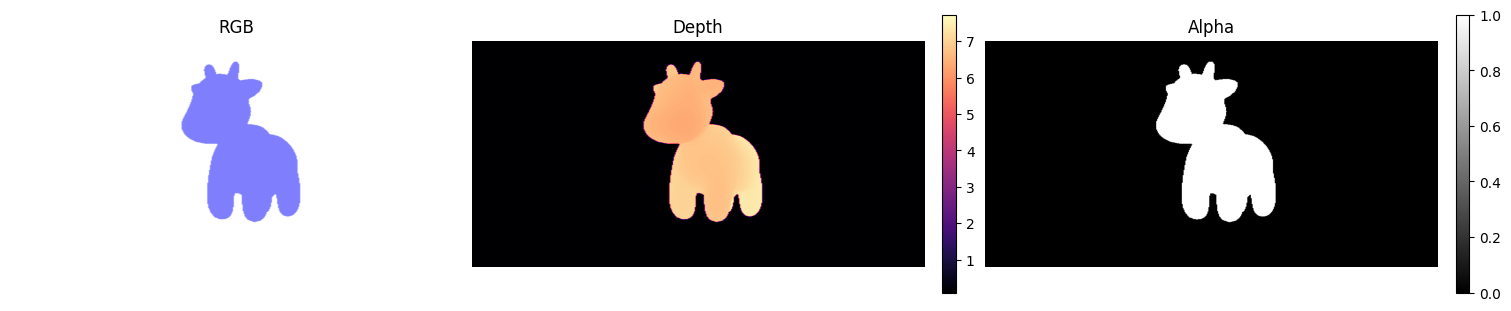

Rendered 3D Gaussians


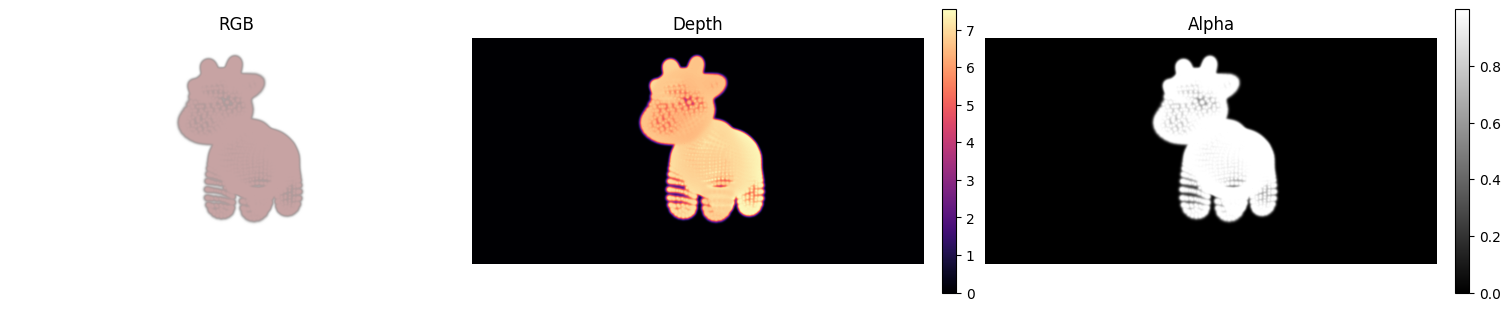

Blended Results


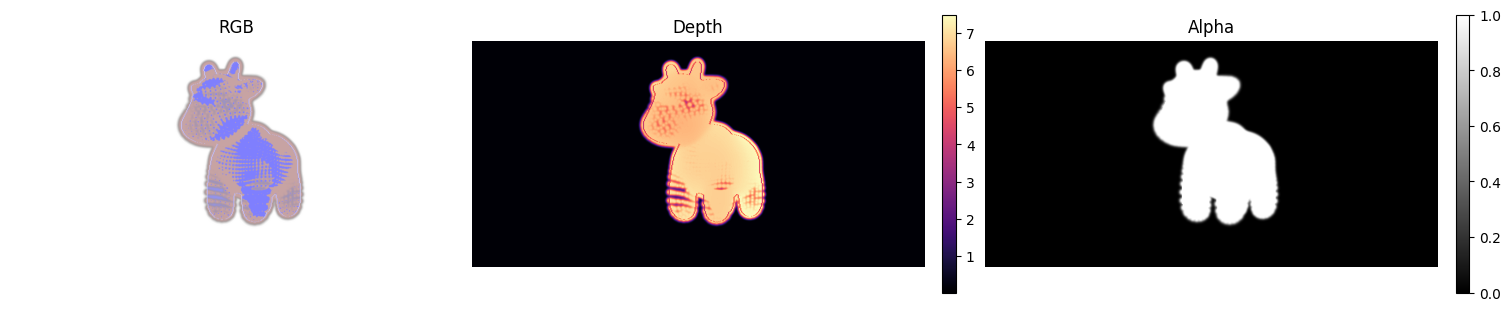

In [19]:
# render the 3D mesh
ret_dict = gmesh_renderer.render(mesh=mesh, gaussians=gaussians, camera_pose=camera_pose, return_all=True)

print('Rendered Mesh')
[rgb, depth, alpha] = ret_dict['mesh']
visualize_rgbd_alpha(rgb, depth, alpha)

print('Rendered 3D Gaussians')
[rgb, depth, alpha] = ret_dict['3dgs']
visualize_rgbd_alpha(rgb, depth, alpha)

print('Blended Results')
[rgb, depth, alpha] = ret_dict['blend']
visualize_rgbd_alpha(rgb, depth, alpha)
